<a href="https://colab.research.google.com/github/tharushaliyanagama/OralCancerEarlyDetection-DSGP/blob/Image-Prediction-and-XAI/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
import shap
import matplotlib.pyplot as plt
import cv2
import os
from typing import Tuple, List


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['cancer', 'non-cancer', 'leukoplakia']

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load the trained model
def load_model(model_path: str, num_classes: int = 3) -> nn.Module:
    """Load the trained ResNet50 model with correct number of classes"""
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    # Load state dict with strict=False to handle size mismatches
    state_dict = torch.load(model_path, map_location=device)

    # Handle size mismatches for fc layer
    if 'fc.weight' in state_dict and state_dict['fc.weight'].shape[0] != num_classes:
        print(f"Warning: Number of classes in model ({state_dict['fc.weight'].shape[0]}) doesn't match expected ({num_classes})")
        del state_dict['fc.weight']
        del state_dict['fc.bias']

    model.load_state_dict(state_dict, strict=False)
    model = model.to(device)
    model.eval()
    return model


In [ ]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def backward(self, outputs: torch.Tensor, class_idx: int):
        outputs[:, class_idx].sum().backward(retain_graph=True)

    def generate(self, x: torch.Tensor, class_idx: int) -> np.ndarray:
        # Forward pass
        self.model.zero_grad()
        output = self.forward(x)

        # Backward pass for specific class
        self.backward(output, class_idx)

        # Pool the gradients and calculate weights
        pooled_gradients = torch.mean(self.gradients, dim=[2, 3], keepdim=True)

        # Weight the activations
        weighted_activations = pooled_gradients * self.activations
        heatmap = torch.mean(weighted_activations, dim=1).squeeze()
        heatmap = torch.relu(heatmap)  # Apply ReLU

        # Normalize heatmap
        heatmap /= torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()

        return heatmap

In [ ]:
def apply_heatmap(heatmap: np.ndarray, image: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    """Apply heatmap to original image"""
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + image * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def load_and_preprocess_image(image_path: str) -> Tuple[torch.Tensor, np.ndarray]:
    """Load and preprocess image for model input"""
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)
    input_tensor = transform(image).unsqueeze(0).to(device)
    return input_tensor, original_image

In [ ]:
def generate_explanation(pred_class: str, confidence: float, top_features: List[str]) -> str:
    """Generate textual explanation for the prediction"""
    explanations = {
        'cancer': [
            "The model detected features commonly associated with cancerous lesions:",
            "- Irregular borders and shape",
            "- Color variegation (mixed red and white areas)",
            "- Possible ulceration or raised surface"
        ],
        'non-cancer': [
            "The model identified features typical of healthy oral tissue:",
            "- Uniform pink coloration",
            "- Smooth, regular surface texture",
            "- No suspicious lesions or discolorations"
        ],
        'leukoplakia': [
            "The model detected features consistent with precancerous leukoplakia:",
            "- Thick white patch that cannot be scraped off",
            "- Rough or wrinkled surface texture",
            "- Possible red areas (erythroleukoplakia)"
        ]
    }

    base_explanation = f"\nThe model classified this image as {pred_class} with {confidence:.1f}% confidence.\n"
    class_explanation = "\n".join(explanations.get(pred_class, ["No specific explanation available."]))
    feature_explanation = f"\nKey influencing features:\n- " + "\n- ".join(top_features)

    return base_explanation + class_explanation + feature_explanation


In [ ]:
def analyze_image(model: nn.Module, image_path: str):
    """Analyze an image and generate visualization and explanation"""
    # Initialize Grad-CAM (targeting the last convolutional layer)
    target_layer = model.layer4[-1].conv3
    grad_cam = GradCAM(model, target_layer)

    # Load and preprocess image
    input_tensor, original_image = load_and_preprocess_image(image_path)

    # Get prediction
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probabilities, 1)
        confidence = confidence.item() * 100
        pred_class = class_names[pred_idx.item()]

    # Generate heatmap
    heatmap = grad_cam.generate(input_tensor, pred_idx.item())

    # Apply heatmap to original image
    heatmap_img = apply_heatmap(heatmap, original_image)

    # Generate explanation
    top_features = ["Lesion border irregularity", "Color variation", "Surface texture", "Contrast with surrounding tissue"]
    explanation = generate_explanation(pred_class, confidence, top_features)

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Activation Heatmap')
    plt.axis('off')

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_img)
    plt.title(f'Prediction: {pred_class}\nConfidence: {confidence:.1f}%')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print explanation
    print("\n" + "="*80)
    print("DIAGNOSTIC EXPLANATION")
    print("="*80)
    print(explanation)
    print("="*80 + "\n")


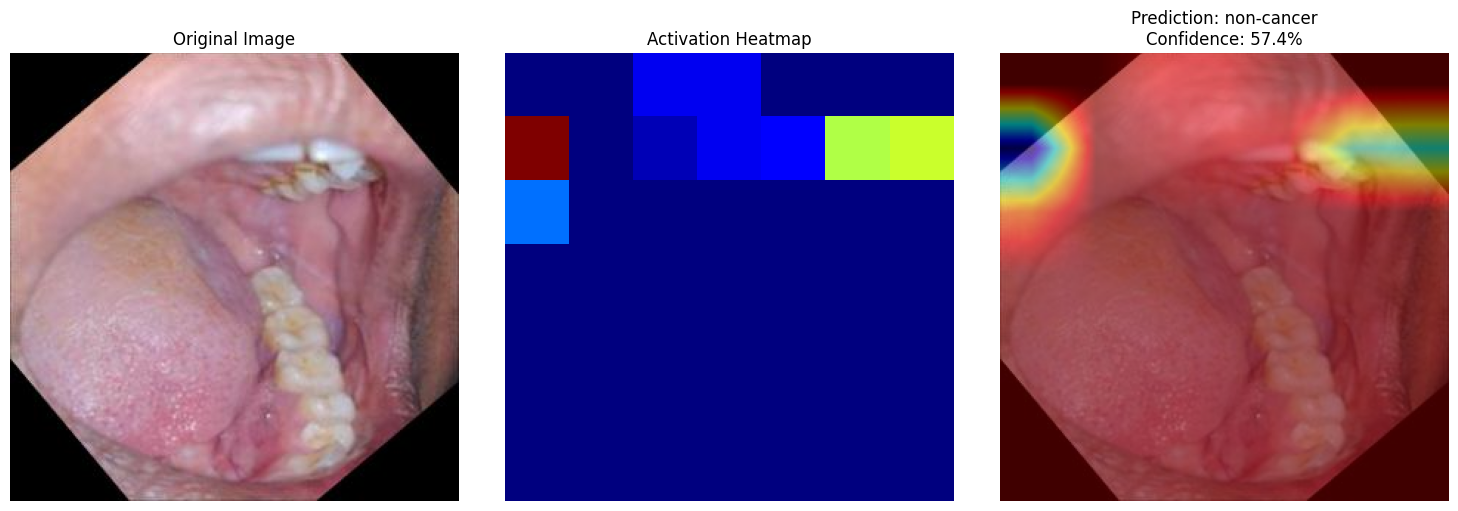


DIAGNOSTIC EXPLANATION

The model classified this image as non-cancer with 57.4% confidence.
The model identified features typical of healthy oral tissue:
- Uniform pink coloration
- Smooth, regular surface texture
- No suspicious lesions or discolorations
Key influencing features:
- Lesion border irregularity
- Color variation
- Surface texture
- Contrast with surrounding tissue



In [ ]:
def main():
    # Path to your trained model
    model_path = r"/content/drive/MyDrive/resnet50_cancer.pth"
    model = load_model(model_path, num_classes=3)

    # Number of classes in your model (must match training)
    num_classes = 3  # Update this if your model has different number of classes

    # Load model
    model = load_model(model_path, num_classes)

    # Example usage - replace with your image path
    image_path = r"/content/drive/MyDrive/cancerous_mouth.jpg"

    if os.path.exists(image_path):
        analyze_image(model, image_path)
    else:
        print(f"Error: Image not found at {image_path}")
        print("Please provide a valid path to an oral lesion image.")

    save_path = "/content/drive/MyDrive/XAI.pth"
    torch.save(model.state_dict(), save_path)

if __name__ == "__main__":
    main()